In [23]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import os

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from matplotlib import pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns

import statsmodels.api as sm

# let's not pollute this blog post with warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [24]:
observations = pd.read_csv(os.path.join('data', 'training_set_observations.csv'), index_col=0)
observations.head()

,site_name,site_id,ccamlr_region,longitude_epsg_4326,latitude_epsg_4326,common_name,day,month,year,season_starting,penguin_count,accuracy,count_type,vantage,e_n
0,Acuna Island,ACUN,48.2,-44.637,-60.7612,chinstrap penguin,28.0,12.0,1983,1983,4000.0,4.0,nests,ground,0.50
1,Acuna Island,ACUN,48.2,-44.637,-60.7612,adelie penguin,NaN,NaN,1993,1993,2008.0,1.0,nests,ground,0.05
2,Acuna Island,ACUN,48.2,-44.637,-60.7612,adelie penguin,NaN,NaN,1994,1994,1920.0,1.0,nests,NaN,0.05
3,Acuna Island,ACUN,48.2,-44.637,-60.7612,adelie penguin,NaN,NaN,2004,2004,1880.0,1.0,nests,ground,0.05
4,Acuna Island,ACUN,48.2,-44.637,-60.7612,adelie penguin,25.0,2.0,2011,2010,3079.0,5.0,nests,vhr,0.90


In [25]:
print(
    "We have {} penguin observations from {} to {} at {} unique sites in the Antarctic!" \
    .format(observations.shape[0],
            observations.season_starting.min(),
            observations.season_starting.max(),
            observations.site_id.nunique())
)


We have 2952 penguin observations from 1895 to 2013 at 619 unique sites in the Antarctic!


In [26]:
observations.common_name.value_counts()


adelie penguin       1387
gentoo penguin        791
chinstrap penguin     774
Name: common_name, dtype: int64

In [27]:
(observations.groupby("common_name")
             .site_id
             .nunique())

common_name
adelie penguin       281
chinstrap penguin    340
gentoo penguin       105
Name: site_id, dtype: int64

In [28]:
(observations.groupby("common_name")
             .count_type
             .value_counts())

common_name        count_type
adelie penguin     nests         976
                   adults        223
                   chicks        188
chinstrap penguin  nests         608
                   adults         86
                   chicks         80
gentoo penguin     nests         629
                   chicks        161
                   adults          1
Name: count_type, dtype: int64

In [29]:
import folium

# Give each species a color
penguin_colors = {
    'adelie penguin': rgb2hex(plt.get_cmap('Set1').colors[0]),
    'chinstrap penguin': rgb2hex(plt.get_cmap('Set1').colors[2]),
    'gentoo penguin': rgb2hex(plt.get_cmap('Set1').colors[3])
}

# Setup a map of Antarctica
ice_map = folium.Map(location=[-69.1759, -11.6016],
                     tiles='Mapbox Bright',
                     zoom_start=2,
                     min_zoom=1)

# Add 500 observations to the map
for i, row in observations.sample(500).iterrows():
    (folium.CircleMarker(location=[row.latitude_epsg_4326, row.longitude_epsg_4326],
                        radius=3 + np.sqrt(row.penguin_count) / 40,
                        color=penguin_colors[row.common_name],
                        fill_color=penguin_colors[row.common_name])
           .add_to(ice_map))

# Display the map
ice_map

In [30]:
nest_counts = pd.read_csv(
                os.path.join('data', 'training_set_nest_counts.csv'),
                index_col=[0,1]
              )

# Let's look at the first 10 rows, and the last 10 columns
nest_counts.iloc[:10, -10:]

2004    2005    2006    2007    2008    2009  \
site_id common_name                                                         
ACUN    adelie penguin     1880.0     NaN     NaN     NaN     NaN     NaN   
        chinstrap penguin     NaN     NaN     NaN     NaN     NaN     NaN   
ADAM    adelie penguin        NaN     NaN     NaN     NaN     NaN    76.0   
ADAR    adelie penguin        NaN     NaN     NaN     NaN     NaN     NaN   
AILS    chinstrap penguin     NaN     NaN     NaN     NaN     NaN     NaN   
AITC    chinstrap penguin     NaN     NaN     NaN     NaN  5620.0     NaN   
        gentoo penguin        NaN  1998.0  1639.0  1383.0  2210.0  1900.0   
AITK    chinstrap penguin     NaN     NaN     NaN     NaN     NaN     NaN   
AKAR    adelie penguin        NaN     NaN     NaN     NaN     NaN     NaN   
ALAS    adelie penguin        NaN     NaN     NaN     NaN  1080.0     NaN   

                               2010    2011  2012      2013  
site_id common_name                                          
ACUN    adelie penguin       3079.0     NaN   NaN       NaN  
        chinstrap penguin       NaN     NaN   NaN       NaN  
ADAM    adelie penguin          NaN     NaN   NaN       NaN  
ADAR    adelie penguin     338231.0     NaN   NaN  428516.0  
AILS    chinstrap penguin       NaN     NaN   NaN       NaN  
AITC    chinstrap penguin       NaN  4047.0   NaN       NaN  
        gentoo penguin       1319.0  2213.0   NaN       NaN  
AITK    chinstrap penguin       NaN     NaN   NaN       NaN  
AKAR    adelie penguin        106.0     NaN   NaN       NaN  
ALAS    adelie penguin          NaN     NaN   NaN       NaN

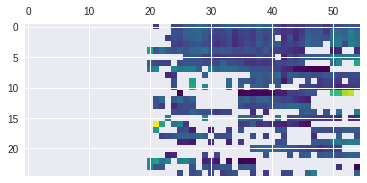

In [31]:
# get a sort order for the sites with the most observations
sorted_idx = (pd.notnull(nest_counts)
                .sum(axis=1)
                .sort_values(ascending=False)
                .index)

# get the top 25 most common sites and divide by the per-series mean
to_plot = nest_counts.loc[sorted_idx].head(25)
to_plot = to_plot.divide(to_plot.mean(axis=1), axis=0)

# plot the data
plt.gca().matshow(to_plot,
                  cmap='viridis')
plt.show()


In [32]:
def preprocess_timeseries(timeseries, first_year, fillna_value=0):
    """ Takes one of the timeseries dataframes, removes
        columns before `first_year`, and fills NaN values
        with the preceeding value. Then backfills any
        remaining NaNs.
        
        As a courtesy, also turns year column name into
        integers for easy comparisons.
    """
    # column type
    timeseries.columns = timeseries.columns.astype(int)
    
    # subset to just data after first_year
    timeseries = timeseries.loc[:, timeseries.columns >= first_year]
   
    # Forward fill count values. This is a strong assumption.
    timeseries.fillna(method="ffill", axis=1, inplace=True)
    timeseries.fillna(method="bfill", axis=1, inplace=True)
    
    # For sites with no observations, fill with fill_na_value
    timeseries.fillna(fillna_value, inplace=True)
    
    return timeseries

nest_counts = preprocess_timeseries(nest_counts,
                                    1980,
                                    fillna_value=0.0)
nest_counts.head()

1980      1981      1982      1983      1984  \
site_id common_name                                                           
ACUN    adelie penguin       2008.0    2008.0    2008.0    2008.0    2008.0   
        chinstrap penguin    4000.0    4000.0    4000.0    4000.0    4000.0   
ADAM    adelie penguin         76.0      76.0      76.0      76.0      76.0   
ADAR    adelie penguin     256806.0  256806.0  256806.0  256806.0  256806.0   
AILS    chinstrap penguin    6000.0    6000.0    6000.0    6000.0    6000.0   

                               1985      1986      1987      1988      1989  \
site_id common_name                                                           
ACUN    adelie penguin       2008.0    2008.0    2008.0    2008.0    2008.0   
        chinstrap penguin    4000.0    4000.0    4000.0    4000.0    4000.0   
ADAM    adelie penguin         76.0      76.0      76.0      76.0      76.0   
ADAR    adelie penguin     256806.0  282307.0  282307.0  272338.0  272338.0   
AILS    chinstrap penguin    6000.0    6000.0    6000.0    6000.0    6000.0   

                             ...         2004      2005      2006      2007  \
site_id common_name          ...                                              
ACUN    adelie penguin       ...       1880.0    1880.0    1880.0    1880.0   
        chinstrap penguin    ...       4000.0    4000.0    4000.0    4000.0   
ADAM    adelie penguin       ...         76.0      76.0      76.0      76.0   
ADAR    adelie penguin       ...     338777.0  338777.0  338777.0  338777.0   
AILS    chinstrap penguin    ...       6000.0    6000.0    6000.0    6000.0   

                               2008      2009      2010      2011      2012  \
site_id common_name                                                           
ACUN    adelie penguin       1880.0    1880.0    3079.0    3079.0    3079.0   
        chinstrap penguin    4000.0    4000.0    4000.0    4000.0    4000.0   
ADAM    adelie penguin         76.0      76.0      76.0      76.0      76.0   
ADAR    adelie penguin     338777.0  338777.0  338231.0  338231.0  338231.0   
AILS    chinstrap penguin    6000.0    6000.0    6000.0    6000.0    6000.0   

                               2013  
site_id common_name                  
ACUN    adelie penguin       3079.0  
        chinstrap penguin    4000.0  
ADAM    adelie penguin         76.0  
ADAR    adelie penguin     428516.0  
AILS    chinstrap penguin    6000.0  

[5 rows x 34 columns]

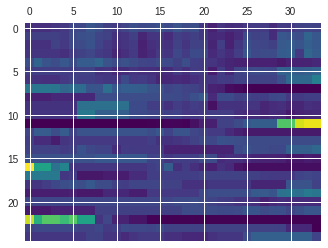

In [33]:
# get the top 25 most common sites and divide by the per-series mean
to_plot = nest_counts.loc[sorted_idx].head(25)
to_plot = to_plot.divide(to_plot.mean(axis=1), axis=0)

plt.gca().matshow(to_plot,
                cmap='viridis')
plt.show()

In [34]:
e_n_values = pd.read_csv(
                 os.path.join('data', 'training_set_e_n.csv'),
                 index_col=[0,1]
             )

# Process error data to match our nest_counts data
e_n_values = preprocess_timeseries(e_n_values, 1980, fillna_value=0.05)
e_n_values.head()

1980  1981  1982  1983  1984  1985  1986  1987  \
site_id common_name                                                         
ACUN    adelie penguin     0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05   
        chinstrap penguin  0.50  0.50  0.50  0.50  0.50  0.50  0.50  0.50   
ADAM    adelie penguin     0.90  0.90  0.90  0.90  0.90  0.90  0.90  0.90   
ADAR    adelie penguin     0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10   
AILS    chinstrap penguin  0.50  0.50  0.50  0.50  0.50  0.50  0.50  0.50   

                           1988  1989  ...   2004  2005  2006  2007  2008  \
site_id common_name                    ...                                  
ACUN    adelie penguin     0.05  0.05  ...   0.05  0.05  0.05  0.05  0.05   
        chinstrap penguin  0.50  0.50  ...   0.50  0.50  0.50  0.50  0.50   
ADAM    adelie penguin     0.90  0.90  ...   0.90  0.90  0.90  0.90  0.90   
ADAR    adelie penguin     0.10  0.10  ...   0.10  0.10  0.10  0.10  0.10   
AILS    chinstrap penguin  0.50  0.50  ...   0.50  0.50  0.50  0.50  0.50   

                           2009  2010  2011  2012  2013  
site_id common_name                                      
ACUN    adelie penguin     0.05   0.9   0.9   0.9   0.9  
        chinstrap penguin  0.50   0.5   0.5   0.5   0.5  
ADAM    adelie penguin     0.90   0.9   0.9   0.9   0.9  
ADAR    adelie penguin     0.10   0.9   0.9   0.9   0.1  
AILS    chinstrap penguin  0.50   0.5   0.5   0.5   0.5  

[5 rows x 34 columns]

In [35]:
def amape(y_true, y_pred, accuracies):
    """ Adjusted MAPE
    """
    not_nan_mask = ~np.isnan(y_true)
    
    # calculate absolute error
    abs_error = (np.abs(y_true[not_nan_mask] - y_pred[not_nan_mask]))
    
    # calculate the percent error (replacing 0 with 1
    # in order to avoid divide-by-zero errors).
    pct_error = abs_error / np.maximum(1, y_true[not_nan_mask])
    
    # adjust error by count accuracies
    adj_error = pct_error / accuracies[not_nan_mask]
    
    # return the mean as a percentage
    return np.mean(adj_error)

In [36]:
amape(nest_counts.values,
      nest_counts.values,
      e_n_values.values)

0.0

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

def train_model_per_row(ts, acc, split_year=2010):
    # Split into train/test to tune our parameter
    train = ts.iloc[ts.index < split_year]
    
    test = ts.iloc[ts.index >= split_year]
    test_acc = acc.iloc[acc.index >= split_year]
    
    # Store best lag parameter
    best_mape = np.inf 
    best_lag = None
  
    # Test linear regression models with the most recent
    # 2 points through using all of the points
    for lag in range(2, train.shape[0]):
        # fit the model
        temp_model = RandomForestRegressor()
        temp_model.fit(
            train.index[-lag:].values.reshape(-1, 1),
            train[-lag:]
        )
        
        # make our predictions on the test set
        preds = temp_model.predict(
                    test.index.values.reshape(-1, 1)
                )

        # calculate the score using the custom metric
        mape = amape(test.values,
                     preds,
                     test_acc.values)

        # if it's the best score yet, hold on to the parameter
        if mape < best_mape:
            best_mape = mape
            best_lag = lag

    # return model re-trained on entire dataset
    final_model = RandomForestRegressor()
    final_model.fit(
        ts.index[-best_lag:].values.reshape(-1, 1),
        ts[-best_lag:]
    )

    return final_model

In [48]:
?RandomForestRegressor

In [43]:
models = {}

for i, row in tqdm_notebook(nest_counts.iterrows(),
                            total=nest_counts.shape[0]):
    acc = e_n_values.loc[i]
    models[i] = train_model_per_row(row, acc)

In [44]:
submission_format = pd.read_csv(
    os.path.join('data','submission_format.csv'),
    index_col=[0, 1]
)

print(submission_format.shape)
submission_format.head()

(648, 4)


2014  2015  2016  2017
site_id common_name                              
ACUN    adelie penguin      0.0   0.0   0.0   0.0
        chinstrap penguin   0.0   0.0   0.0   0.0
ADAM    adelie penguin      0.0   0.0   0.0   0.0
ADAR    adelie penguin      0.0   0.0   0.0   0.0
AILS    chinstrap penguin   0.0   0.0   0.0   0.0

In [45]:
preds = []

# For every row in the submission file
for i, row in tqdm_notebook(submission_format.iterrows(),
                            total=submission_format.shape[0]):
    
    # get the model for this site + common_name
    model = models[i]
    
    # make predictions using the model
    row_predictions = model.predict(
        submission_format.columns.values.reshape(-1, 1)
    )
       
    # keep our predictions, rounded to nearest whole number
    preds.append(np.round(row_predictions))

# Create a dataframe that we can write out to a CSV
prediction_df = pd.DataFrame(preds,
                             index=submission_format.index,
                             columns=submission_format.columns)

prediction_df.head()

2014      2015      2016      2017
site_id common_name                                              
ACUN    adelie penguin       3079.0    3079.0    3079.0    3079.0
        chinstrap penguin    4000.0    4000.0    4000.0    4000.0
ADAM    adelie penguin         76.0      76.0      76.0      76.0
ADAR    adelie penguin     419488.0  419488.0  419488.0  419488.0
AILS    chinstrap penguin    6000.0    6000.0    6000.0    6000.0

In [47]:
prediction_df.to_csv('predictions.csv')